In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 문제 1

사용할 데이터 : house.csv

네이버 부동산에서 크롤링해 가져온 서울시 부동산 데이터

* Unnamed: 0 : 의미없는 칼럼
* id : 매물id
> 한 매물당 하나의 id가 할당된다.
* lat : 위도
* lng : 경도
* gu : 구(행정지역정보)
* goodsType : 매물의 거래형태(아파트,빌라 등)
* payType : 판매의 거래형태(월세,매매 등)
* floor : 매물방의 층수
* floor_total : 매물이 있는 전체 건물의 층수
* contractArea : 계약면적
* realArea : 실제면적
* direction : 창문방향(남향,북향)
* tag : 매물마다 관련된 설명정보
> ex. 일조량 및 관리 잘 된 복층
* tagList : 매물마다 관련된 설명에서의 태그
> ex. '10년이내, 25년이내 건축, 복층'과 같이 인스타 해시테그 느낌
* deposit : 보증금
* monthlyPay : 월세


> 데이터 출처 : 네이버 부동산 크롤링 데이터

설명
* X와 y를 찾아, LinearRegression을 위 예제1을 참고하여 실행하시오.
* 예를 들면, y='보증금', X=나머지 으로 하여 나머지 값으로 보증금을 예측하는 선형회귀문제로 Task를 정해 코딩을 진행

* 조건
> * ***(핵심내용)*** X & y로 이용할 것을 명확히 제시하고, y에 따른 어떤 문제인지 파악하기
>    * y를 연속형으로 하여, LinearRegression문제가 될 수 있도록 한다.
> * X변수에 1개이상의 범주형데이터를 포함하고, one-hot encoding을 사용하기
> * 최소 1가지 이상의 방법으로 X데이터 중 1개 이상의 열을 삭제하기
> * 데이터 분할 진행하기
> * ***(핵심내용)*** 다중선형회귀 모델을 사용하기
> * 규제항이 있는 모델(Ridge,Lasso)을 사용하기
> * hyper-parameter 튜닝을 진행하기
>   * cross_val_score를 사용하지 않아도 됩니다.
>   * GridSearchCV ,RandomSearchCV을 사용하셔도 됩니다.
>   * 참고자료 : https://dacon.io/codeshare/
> * ***(핵심내용)*** 변수 중요도 해석
>   * 스케일링 없이
>   * min-max scaling
>   * standard scaling

## 1. 데이터 확인

In [2]:
house = pd.read_csv('data/house.csv')
house.head(2)

,Unnamed: 0,id,lat,lng,gu,goodsType,payType,floor,floor_total,contractArea,realArea,direction,tag,tagList,deposit,monthlyPay
0,0,2233636969,37.677967,127.041725,dobong,아파트,매매,5,5,81,63,남향,ok. 일조량 및 관리 잘 된 복층,"['10년이내', '역세권', '복층', '탑층']",63000,0
1,3,2232935032,37.657623,127.044115,dobong,아파트,매매,15,24,154,119,남향,기본 로얄동 로얄층 채광 GOOD,"['25년이내', '대단지', '대형평수', '방네개이상']",140000,0


In [3]:
print(house.shape)
print('-'*10)
print(house.columns)
print('-'*10)
house.isnull().sum()

(93995, 16)
----------
Index(['Unnamed: 0', 'id', 'lat', 'lng', 'gu', 'goodsType', 'payType', 'floor',
       'floor_total', 'contractArea', 'realArea', 'direction', 'tag',
       'tagList', 'deposit', 'monthlyPay'],
      dtype='object')
----------


Unnamed: 0         0
id                 0
lat                0
lng                0
gu                 0
goodsType          0
payType            0
floor              0
floor_total        0
contractArea       0
realArea           0
direction       3204
tag             4529
tagList            0
deposit            0
monthlyPay         0
dtype: int64

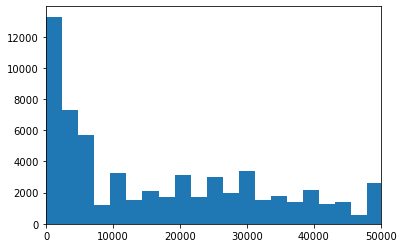

In [4]:
# 분석하고자 하는 연속값 = 보증금 (deposit)

y = house.loc[:, 'deposit']

plt.hist(y.values, bins = 1000)
plt.xlim([0, 50000])
plt.show()

In [6]:
X_features = house.drop(['deposit'], axis = 1)
X_features.head(3)

,Unnamed: 0,id,lat,lng,gu,goodsType,payType,floor,floor_total,contractArea,realArea,direction,tag,tagList,monthlyPay
0,0,2233636969,37.677967,127.041725,dobong,아파트,매매,5,5,81,63,남향,ok. 일조량 및 관리 잘 된 복층,"['10년이내', '역세권', '복층', '탑층']",0
1,3,2232935032,37.657623,127.044115,dobong,아파트,매매,15,24,154,119,남향,기본 로얄동 로얄층 채광 GOOD,"['25년이내', '대단지', '대형평수', '방네개이상']",0
2,4,2232502309,37.645001,127.040034,dobong,빌라,전세,3,4,38,33,남향,올수리 베란다크고 주차 남향 초등학교 대형마트 재래시장 5분,"['25년이상', '융자금적은', '올수리', '화장실한개']",0


In [7]:
# 전처리 전 불필요한 칼럼을 제거하겠습니다.
# Unnamed:0 = index값
# id = 아이디 번호
# tag = tagList을 전처리 후 사용할 예정이므로 제외

X_features.drop(columns = ['Unnamed: 0', 'id', 'tag'], inplace = True)

## 2. 전처리

In [8]:
X_features.dtypes

lat             float64
lng             float64
gu               object
goodsType        object
payType          object
floor             int64
floor_total       int64
contractArea      int64
realArea          int64
direction        object
tagList          object
monthlyPay        int64
dtype: object

In [9]:
X_features.isnull().sum()

lat                0
lng                0
gu                 0
goodsType          0
payType            0
floor              0
floor_total        0
contractArea       0
realArea           0
direction       3204
tagList            0
monthlyPay         0
dtype: int64

In [10]:
# direction 3204개의 결측치를 처리하겠습니다.

X_features.loc[:, 'direction'].value_counts()

남향     29214
남동향    16395
남서향    13189
동향     13111
서향      7084
북향      5091
북동향     3664
북서향     3043
Name: direction, dtype: int64

In [11]:
# direction은 주택이 향하는 각 방향을 지시하고 있으므로
# 결측치는 새롭게 NULL string을 넣어주겠습니다.

X_features.loc[:, 'direction'] = X_features.loc[:, 'direction'].apply(lambda x : 'NULL' if x != x else x)

In [12]:
# 결측치를 전부 처리했습니다.

X_features.isnull().sum()

lat             0
lng             0
gu              0
goodsType       0
payType         0
floor           0
floor_total     0
contractArea    0
realArea        0
direction       0
tagList         0
monthlyPay      0
dtype: int64

## 다중공산성으로 불필요한 변수 제거

In [14]:
cor_matrix = abs(X_features.corr())

for _ in range(len(cor_matrix.columns)):
    cor_matrix.iloc[_, _] = 0
    
cor_matrix

,lat,lng,floor,floor_total,contractArea,realArea,monthlyPay
lat,0.000000,0.288140,0.043027,0.057064,0.001071,0.007107,0.003088
lng,0.288140,0.000000,0.008279,0.008518,0.000098,0.006610,0.001625
floor,0.043027,0.008279,0.000000,0.658059,0.000462,0.072648,0.002466
floor_total,0.057064,0.008518,0.658059,0.000000,0.002100,0.087085,0.001066
contractArea,0.001071,0.000098,0.000462,0.002100,0.000000,0.040837,0.001193
realArea,0.007107,0.006610,0.072648,0.087085,0.040837,0.000000,0.026251
monthlyPay,0.003088,0.001625,0.002466,0.001066,0.001193,0.026251,0.000000


In [21]:
# 상관관수값이 가장 큰 두 축을 확인하겠습니다.

idx = np.where(cor_matrix == cor_matrix.max().max())[0]
print(f'columns of max corr : {cor_matrix.columns[idx[0]]} & { cor_matrix.columns[idx[1]]}')
print(f'corr val : {cor_matrix.iloc[idx[0], idx[1]]:.3f}')

columns of max corr : floor & floor_total
corr val : 0.658


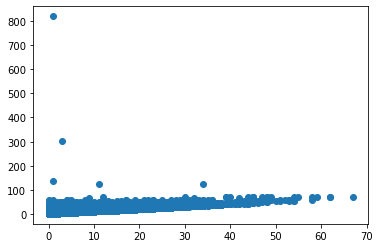

In [22]:
# 산점도를 그려 확인하겠습니다. 제거할 정도로 상관관계가 높지 않아 제거하지 않겠습니다.

plt.scatter(house.floor, house.floor_total)

## VIF으로 불필요한 변수 제거

In [27]:
float_X = X_features.select_dtypes(exclude = 'object')

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['features'] = float_X.columns
vif['VIF_Factor'] = [variance_inflation_factor(float_X.values, _) for _ in range(float_X.shape[1])]

vif

,features,VIF_Factor
0,lat,532878.742675
1,lng,533007.039978
2,floor,3.651550
3,floor_total,4.841711
4,contractArea,1.002494
5,realArea,1.315433
6,monthlyPay,1.000787


In [30]:
#lat와 lng가 상당히 큰 VIF_Factor를 지니고 있습니다.
# 두 값을 제거합니다.

X1_features = X_features.drop(['lat', 'lng'], axis = 1)
X1_features.columns

Index(['gu', 'goodsType', 'payType', 'floor', 'floor_total', 'contractArea',
       'realArea', 'direction', 'tagList', 'monthlyPay'],
      dtype='object')

## 변수 중요도 확인

In [32]:
# StandardScalar로 float형태 데이터를 전처리하겠습니다.

from sklearn.preprocessing import StandardScaler

t_data = pd.concat([X1_features, y], axis = 1)
t1_data = t_data.select_dtypes(exclude = 'object')

scaler = StandardScaler()
scaler.fit(t1_data)
s = scaler.transform(t1_data)

t2_data = pd.DataFrame(data = s, columns = t1_data.columns)
X2_features = pd.concat([t2_data, t_data.select_dtypes(include = 'object')], axis = 1)

X2_features.head(1)

,floor,floor_total,contractArea,realArea,monthlyPay,deposit,gu,goodsType,payType,direction,tagList
0,-0.167492,-0.755197,-0.011043,-0.124472,-0.008482,0.180513,dobong,아파트,매매,남향,"['10년이내', '역세권', '복층', '탑층']"


## 원핫-인코딩 진행

In [33]:
#gu 변수 인코딩 진행

np.unique(X2_features.loc[:, 'gu'])

array(['dobong', 'dongdaemun', 'dongjak', 'eunpyeong', 'gangbuk',
       'gangdong', 'gangnam', 'gangseo', 'guemcheon', 'guro', 'gwanak',
       'gwangjin', 'jongno', 'jung', 'jungnang', 'mapo', 'nowon',
       'seocho', 'seodaemun', 'seongbuk', 'seongdong', 'songpa',
       'yangcheon', 'yeongdeungpo', 'yongsan'], dtype=object)

In [34]:
encoding_gu = pd.get_dummies(X2_features.loc[:, 'gu'])
encoding_gu

,dobong,dongdaemun,dongjak,eunpyeong,gangbuk,gangdong,gangnam,gangseo,guemcheon,guro,...,mapo,nowon,seocho,seodaemun,seongbuk,seongdong,songpa,yangcheon,yeongdeungpo,yongsan
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93990,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93991,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93992,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93993,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
# goodsType 인코딩 진행

np.unique(X2_features.loc[:, 'goodsType'])

array(['단독/다가구', '빌라', '사무실', '상가', '상가주택', '아파트', '아파트분양권', '오피스텔',
       '오피스텔분양권', '원룸', '재개발', '재건축', '전원주택', '지식산업센터', '한옥주택'],
      dtype=object)

In [36]:
encoding_goodsType = pd.get_dummies(X2_features.loc[:, 'goodsType'])
encoding_goodsType

,단독/다가구,빌라,사무실,상가,상가주택,아파트,아파트분양권,오피스텔,오피스텔분양권,원룸,재개발,재건축,전원주택,지식산업센터,한옥주택
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93990,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
93991,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
93992,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
93993,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [37]:
#payType 인코딩 진행

np.unique(X2_features.loc[:, 'payType'])

array(['단기임대', '매매', '월세', '전세'], dtype=object)

In [38]:
encoding_payType = pd.get_dummies(X2_features.loc[:, 'payType'])
encoding_payType

,단기임대,매매,월세,전세
0,0,1,0,0
1,0,1,0,0
2,0,0,0,1
3,0,1,0,0
4,0,0,1,0
...,...,...,...,...
93990,0,0,1,0
93991,0,0,0,1
93992,0,0,0,1
93993,0,1,0,0


In [39]:
# direction 인코딩 진행

np.unique(X2_features.loc[:, 'direction'])

array(['NULL', '남동향', '남서향', '남향', '동향', '북동향', '북서향', '북향', '서향'],
      dtype=object)

In [40]:
encoding_direction = pd.get_dummies(X2_features.loc[:, 'direction'])
encoding_direction

,NULL,남동향,남서향,남향,동향,북동향,북서향,북향,서향
0,0,0,0,1,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
93990,0,0,0,1,0,0,0,0,0
93991,0,0,0,1,0,0,0,0,0
93992,0,1,0,0,0,0,0,0,0
93993,0,0,0,0,0,0,0,1,0


In [41]:
# Taglist 인코딩 진행
# Tag가 string형태 리스트로 저장되어 있다.

np.unique(X2_features.loc[:, 'tagList'])

array(["['10년이내', '1층', '관리비10만원이하', '남동향']",
       "['10년이내', '1층', '관리비10만원이하', '엘리베이터']",
       "['10년이내', '1층', '관리비10만원이하', '주차가능']", ...,
       "['화장실한개', '소형평수', '방두개']", "['화장실한개', '소형평수', '방세개']", '[]'],
      dtype=object)

In [42]:
# 정규표현식으로 단어 제외 나머지 punctuation을 제거한 후, 새롭게 리스트로 반환한다.

import re

def regdex(sentence):
    sentence = re.sub(r"([,.?'!])", r"", sentence[1:-1])
    sentence = sentence.split(' ')
    
    return sentence

tag = np.array([regdex(X2_features['tagList'][_]) for _ in range(len(X2_features['tagList']))])

C:\Users\user\AppData\Local\Temp\ipykernel_10176\560327000.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tag = np.array([regdex(X2_features['tagList'][_]) for _ in range(len(X2_features['tagList']))])


In [43]:
# 결과

tag[:3]

array([list(['10년이내', '역세권', '복층', '탑층']),
       list(['25년이내', '대단지', '대형평수', '방네개이상']),
       list(['25년이상', '융자금적은', '올수리', '화장실한개'])], dtype=object)

In [44]:
# tagList내 단어 전부를 하나의 리스트로 extend한다.

re = []

for j in tag:
    re.extend(j)

In [45]:
# tagList내 독립적인 단어

np.unique(re)

array(['', '10년이내', '15년이내', '15대이상', '1층', '25년이내', '25년이상', '2년이내',
       '4년이내', 'CCTV', '고층', '관리비10만원이하', '관리비20만원이하', '관리비30만원이하',
       '관리비40만원이하', '관리비50만원이하', '관리비60만원이하', '관리비70만원이하', '관리비80만원이하',
       '급매', '남동향', '남서향', '남향', '대단지', '대형평수', '동향', '마당', '무보증',
       '방네개이상', '방두개', '방세개', '방한개', '베란다', '보안', '보일러교체', '복층', '북동향',
       '북서향', '북향', '붙박이장', '비디오폰', '서향', '세대당', '세대당1대', '세대분리', '세안고',
       '소형전월세', '소형평수', '신발장', '싱크대', '에어컨', '엘리베이터', '역세권', '올수리',
       '욕실수리', '융자금없는', '융자금적은', '인터폰', '저층', '주방교체', '주차가능', '중층',
       '천장에어컨', '총2층', '총3층', '총4층', '총5층', '탑층', '테라스', '펜트하우스', '풀옵',
       '필로티', '현관보안', '화장실네개이상', '화장실두개', '화장실세개', '화장실한개', '화재경보기',
       '확장형'], dtype='<U9')

In [46]:
# tagList내 독립적인 단어의 갯수

len(np.unique(re))

79

In [47]:
# One-Hot Encoding.
# 93995 x 79 크기의 zeros dataframe을 생성 후,
# 리스트 내 tag가 있으면 1을 더해주는 식으로
# One-Hot Encoding 진행

from tqdm import tqdm

zeros = np.zeros((len(tag), len(np.unique(re))))

taglist = pd.DataFrame(zeros, columns = np.unique(re))

for _ in tqdm(range(len(taglist))):
    for i in tag[_]:
        taglist.loc[_, i] += 1.0

100%|██████████████████████████████████████████████████████████████████████████| 93995/93995 [00:23<00:00, 3972.84it/s]


In [48]:
# 결과

encoding_tagList = taglist[taglist.columns[1:]]
encoding_tagList

,10년이내,15년이내,15대이상,1층,25년이내,25년이상,2년이내,4년이내,CCTV,고층,...,펜트하우스,풀옵,필로티,현관보안,화장실네개이상,화장실두개,화장실세개,화장실한개,화재경보기,확장형
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93990,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93991,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93992,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93993,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 데이터 분할

In [49]:
X2_features.columns

Index(['floor', 'floor_total', 'contractArea', 'realArea', 'monthlyPay',
       'deposit', 'gu', 'goodsType', 'payType', 'direction', 'tagList'],
      dtype='object')

In [51]:
# 모든 칼럼들을 합친 다음 train_test_split으로 분할합니다.

data = pd.concat([X2_features.select_dtypes(exclude = 'object'),
                 encoding_gu, encoding_goodsType,
                 encoding_payType, encoding_direction,
                 encoding_tagList], axis = 1)

In [53]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.drop(['deposit'], axis = 1),
                                                   data.loc[:, 'deposit'],
                                                   train_size = 0.8,
                                                   test_size = 0.2,
                                                   random_state = 1)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(75196, 136) (18799, 136) (75196,) (18799,)


## 하이퍼파라미터 튜닝

In [54]:
# MSE, RMSE, RMSLE 정의

from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_regr(y, pred):
    rmse_val = np.sqrt(mean_squared_error(y, pred))
    mae_val = mean_absolute_error(y, pred)
    
    print(f'RMSE : {rmse_val:.3f}, MAE : {mae_val:.3f}')
    return (rmse_val, mae_val)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:27<00:00,  5.42s/it]


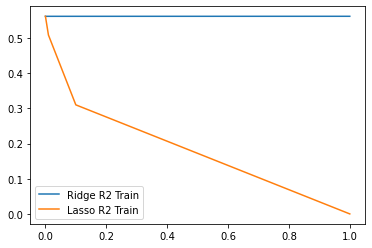

In [56]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn import metrics
from sklearn.metrics import r2_score

alpha_list = [0.0001, 0.001, 0.01, 0.1, 1]

ridge_r2_list_train = []
ridge_r2_list_test = []
lasso_r2_list_train = []
lasso_r2_list_test = []

for alpha in tqdm(alpha_list):
    ridge_model = Ridge(alpha = alpha)
    lasso_model = Lasso(alpha = alpha)
    
    ridge_r2_list_train.append(np.mean(cross_val_score(ridge_model,
                                                       X_train, y_train,
                                                       scoring='r2', cv=10)))
    lasso_r2_list_train.append(np.mean(cross_val_score(lasso_model,
                                                       X_train, y_train,
                                                       scoring='r2',cv=10)))
    
plt.plot(alpha_list, ridge_r2_list_train, label='Ridge R2 Train')
plt.plot(alpha_list, lasso_r2_list_train, label='Lasso R2 Train')

plt.legend()  

In [57]:
ridge_r2_list_train

[0.5621786521806691,
 0.5621787373035525,
 0.5621795836126365,
 0.5621876122897739,
 0.5622480643605925]

In [58]:
lasso_r2_list_train

[0.5623920121920885,
 0.5576512372670968,
 0.5089626977801343,
 0.31019826281161667,
 -0.00018193375457800087]

In [59]:
# 가장 성능이 좋은 모델의 hyper-parameter 확인

idx1 = np.array(ridge_r2_list_train).argsort()[::-1][0] # 가장 큰 것의 index
idx2 = np.array(lasso_r2_list_train).argsort()[::-1][0] # 가장 큰 것의 index

print('Ridge best alpha :', alpha_list[idx1])
print('Lasso best alpha :', alpha_list[idx2])

Ridge best alpha : 1
Lasso best alpha : 0.0001


In [60]:
ridge = Ridge(alpha = 1)
lasso = Lasso(alpha = 0.0001)

ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

print(f'R^2 Ridge score : {r2_score(y_test, ridge.predict(X_test)):.4f}')
print(f'R^2 Lasso score : {r2_score(y_test, lasso.predict(X_test)):.4f}')

print(f'MSE Ridge score : {mean_squared_error(y_test, ridge.predict(X_test)):.4f}')
print(f'MSE Lasso score : {mean_squared_error(y_test, lasso.predict(X_test)):.4f}')

R^2 Ridge score : 0.5299
R^2 Lasso score : 0.5299
MSE Ridge score : 0.4957
MSE Lasso score : 0.4956


RMSE : 0.704, MAE : 0.333


<BarContainer object of 2 artists>

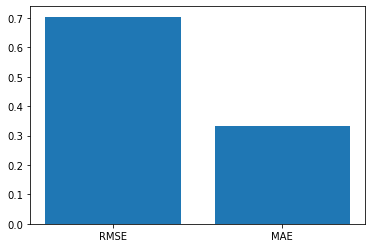

In [62]:
ridge_pred = ridge.predict(X_test)

ridge_result = evaluate_regr(y_test, ridge_pred)
plt.bar(['RMSE', 'MAE'], ridge_result)

RMSE : 0.704, MAE : 0.332


<BarContainer object of 2 artists>

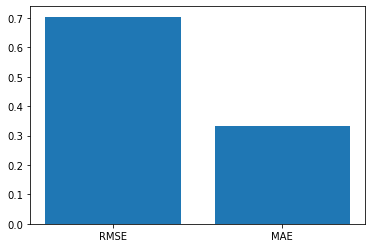

In [63]:
lasso_pred = lasso.predict(X_test)

lasso_result = evaluate_regr(y_test, lasso_pred)
plt.bar(['RMSE', 'MAE'], lasso_result)

## 결론

> Ridge와 Lasso 규제는 거의 동일한 효과를 나타냈다 <br>
> $R^2$ 값은 0.53이 나왔지만 MSE, MAE, RMSE가 아주 적은 값이 나왔다..!!<br>
> one-hot encoding쪽에서 조금 더 다듬으면 더 높은 R2score값을 기대 가능합니다.

# 이론 문제

**1.SVM의 수리적 모델링에서, 목적함수를 적고 증명과정을 서술하시오**

The ideal hyperplane = $w_0 + w_1X_1 + w_2X_2 = 0$

vectors located higher than the hyperplane : $w_0 + w_1X_1 + w_2X_2 >= +M/2$<br>
vectors located lower than the hyperplane : $w_0 + w_1X_1 + w_2X_2 <= -M/2$

1. $y_i(W \circ X_i + w_0) \ge M/2$
2. $y_i(W \circ X_i + w_0) \ge M/2 - \xi_i$

-->

$y_i(W \circ X_i + w_0) \ge M/2 - \xi_i$, <br> $\xi_i \ge 0$

-->

$y_i[(W \circ X_i) + w_0] \ge 1 - \xi_i ( i = 1, ... , n)$, <br> $\xi \ge 0$


-->

$Max M = Max\frac{2}{||W||} = Min\frac{||W||}{2} = Min\frac{{||W||}^2}{2}$

Objective Function : $Min\frac{{||W||}^2}{2} + C\Sigma_i\xi_i$

**2. 시그모이드 함수의 공식, 정의역, 치역을 작성하시오**

$\frac{1}{1 + e^{-(\beta_0 + \beta_1x_1 + ... + \beta_kx_k)}} = Sigmoid Function$

정의역 = $(-\infty, \infty)$ <br>
공역 = [0, 1]

**3. 코드 실습 영상을 참고하여, 아래 그림과 같은 데이터의 F1-score를 계산하시오**

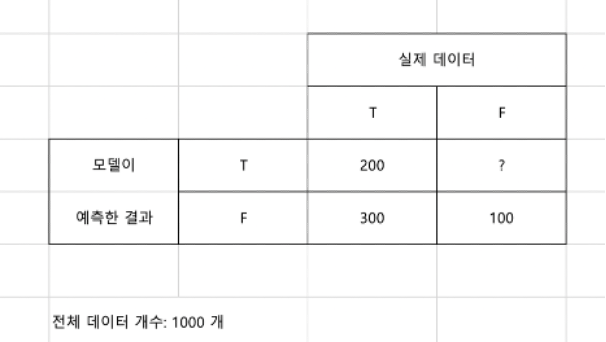

FP = 1000 - 200 - 300 - 100 = 400

재현율 = TP/(FN + TP)

recall = 200/(300 + 200) = 0.4

정밀도 = TP/(FP + TP)

precision = 200(200 + 400) = 0.33

F1-score = 2/((1/재현율) + (1/정밀도))

f1-score = 2/(10/3 + 10/4) = 0.343

$\therefore f1-score = 0.343$